# 2. Ingeniería de características I

## 2.1. Transformación Temporal

Para alimentar la arquitectura híbrida descrita en los objetivos, es necesario transformar los datos tabulares de interacción en **series temporales estructuradas**. Esta representación sirve a un doble propósito metodológico:

1.  **Entrada para el Modelo Supervisado (Transformer):** Permite capturar dependencias secuenciales a largo plazo (Objetivo 2.2).
2.  **Base para el Modelo No Supervisado (Clustering):** Proporciona los vectores de comportamiento dinámico necesarios para identificar arquetipos de estudiantes (Objetivo 2.1).

A diferencia de los enfoques tradicionales que agregan la actividad en una única métrica estática (*total clics*), esta fase descompone el comportamiento del estudiante en una secuencia de pasos semanales. Esto permite al modelo capturar la **dinámica evolutiva del aprendizaje**, diferenciando entre un estudiante constante y uno que abandona progresivamente.

**Estrategia de Modelado Temporal:**
Se ha definido una ventana de observación que cubre el ciclo de vida completo del curso, aplicando una estrategia de *Bucketing* para gestionar los extremos temporales sin perder información:

1.  **Resolución Fina (Semanas -2 a 35):** El núcleo del curso se modela con granularidad semanal para detectar patrones precisos de riesgo.
2.  **Agregación de Colas (`Buckets`):**
    *   `w_prev`: Acumula toda la actividad histórica previa a la semana -2 (fase de matrícula y exploración temprana).
    *   `w_post`: Agrupa la actividad remanente tras la semana 35 (cierres administrativos y recuperaciones tardías).


In [ ]:
# --- ESTRATEGIA AVANZADA: BUCKETING CORREGIDO ---

# 1. Definimos los límites
WEEK_START = -2
WEEK_END = 35

# 2. Pivotamos (Matriz cruda, solo claves numéricas por ahora)
ts_full = weekly_clicks.groupby(['unique_id', 'week'])['sum_click'].sum().unstack(fill_value=0)

# Aseguramos que las columnas sean floats/ints puros
# A veces Pandas deja nombres raros si hay NaNs en el índice
ts_full.columns = ts_full.columns.astype(float)

# Listamos las columnas disponibles (que son números de semana)
available_weeks = ts_full.columns.tolist()

# 3. Identificamos columnas para cada bucket
cols_prev = [c for c in available_weeks if c < WEEK_START]
cols_core = [c for c in available_weeks if WEEK_START <= c <= WEEK_END]
cols_post = [c for c in available_weeks if c > WEEK_END]

# 4. Construimos el nuevo DataFrame paso a paso
ts_buckets = pd.DataFrame(index=ts_full.index)

# Bucket Previo
ts_buckets['w_prev'] = ts_full[cols_prev].sum(axis=1) if cols_prev else 0

# Núcleo Central (copiamos tal cual)
for c in cols_core:
    col_name = f'w_{int(c)}' if c >= 0 else f'w_neg{abs(int(c))}'
    ts_buckets[col_name] = ts_full[c]

# Bucket Posterior
ts_buckets['w_post'] = ts_full[cols_post].sum(axis=1) if cols_post else 0

# 5. Reindexar con todos los estudiantes (recuperar inactivos)
ts_final = ts_buckets.reindex(all_enrollments, fill_value=0)

# 6. Log Transform
ts_final_log = np.log1p(ts_final)

print(f"Matriz Final con Buckets: {ts_final_log.shape}")
print("Columnas:", list(ts_final_log.columns[:5]) + ["..."] + list(ts_final_log.columns[-5:]))
display(ts_final_log.sample(5))

Matriz Final con Buckets: (22815, 40)
Columnas: ['w_prev', 'w_neg2', 'w_neg1', 'w_0', 'w_1', '...', 'w_32', 'w_33', 'w_34', 'w_35', 'w_post']


,w_prev,w_neg2,w_neg1,w_0,w_1,w_2,w_3,w_4,w_5,w_6,...,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_post
unique_id,,,,,,,,,,,,,,,,,,,,,
516653_DDD_2013J,0.0000,3.367296,2.079442,2.302585,2.197225,4.828314,4.043051,2.564949,1.098612,2.995732,...,2.995732,3.688879,2.639057,0.000000,0.000000,0.000000,2.397895,0.000000,0.0,0.000000
646470_GGG_2014J,0.0000,0.000000,0.000000,0.000000,2.197225,0.000000,3.218876,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
605111_EEE_2013J,0.0000,2.639057,3.583519,3.663562,5.062595,2.302585,4.465908,5.894403,2.995732,4.043051,...,4.276666,1.945910,0.000000,0.000000,2.397895,3.433987,4.682131,2.708050,0.0,0.000000
199897_AAA_2014J,0.0000,0.000000,0.000000,3.401197,3.555348,5.587249,5.181784,2.639057,3.761200,4.043051,...,4.204693,4.653960,3.332205,4.077537,3.555348,4.234107,4.700480,4.060443,0.0,1.791759
528892_DDD_2013J,3.7612,0.000000,2.944439,3.401197,2.995732,1.791759,3.496508,2.484907,2.079442,3.912023,...,0.000000,2.197225,2.302585,2.484907,0.000000,3.218876,3.761200,0.000000,0.0,2.944439


### **Justificación Técnica: Bucketing Logarítmico**

Tras la generación de la matriz temporal, se observa que la distribución de la actividad sigue una **Ley de Potencia** (Power Law): la mayoría de estudiantes genera pocos clics semanales, mientras que una minoría ("power users") genera miles.

Esta dispersión extrema dificulta la convergencia de las redes neuronales, cuyos gradientes son sensibles a las magnitudes de entrada. Para mitigar este problema sin eliminar la información de los valores altos, se aplica una transformación no lineal:

$$ x' = \log(1 + x) $$

**Resultados de la Transformación:**
*   **Compresión de Rango:** La escala original [0, ~7000] se reduce a un espacio denso [0, ~9.0], mucho más amigable para el entrenamiento.
*   **Normalización de Distribución:** Se suaviza el sesgo (skewness) de la distribución, acercándola a una normalidad que favorece el aprendizaje de los pesos en las capas de atención del Transformer.


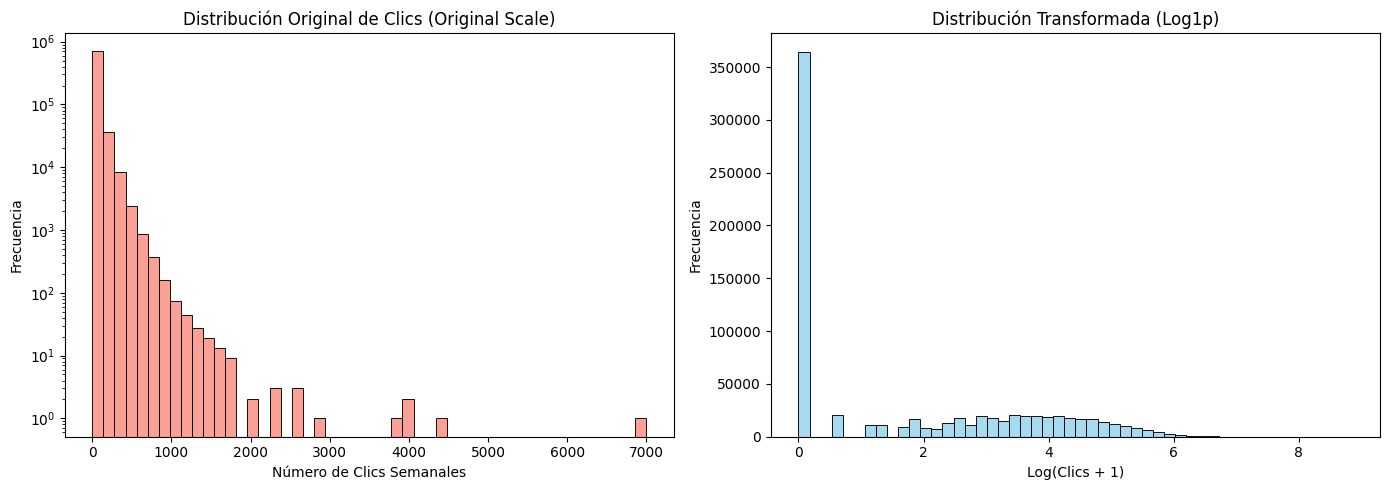

Estadísticas tras transformación:
Mínimo: 0.0
Máximo: 8.85 (Equivalente a 6999 clics reales)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aplicamos Logaritmo (log1p para manejar ceros de forma segura: log(x+1))
ts_clicks_log = np.log1p(ts_clicks)

# 2. Visualización Comparativa: ¿Por qué hicimos esto?
plt.figure(figsize=(14, 5))

# Gráfico A: Datos Originales (Muy sesgados)
plt.subplot(1, 2, 1)
# Aplanamos la matriz para ver la distribución global de clics
sns.histplot(ts_clicks.values.flatten(), bins=50, color='salmon')
plt.title("Distribución Original de Clics (Original Scale)")
plt.xlabel("Número de Clics Semanales")
plt.ylabel("Frecuencia")
plt.yscale('log') # Escala log en Y para ver algo, si no sería una sola barra

# Gráfico B: Datos Logarítmicos (Distribución casi Normal)
plt.subplot(1, 2, 2)
sns.histplot(ts_clicks_log.values.flatten(), bins=50, color='skyblue')
plt.title("Distribución Transformada (Log1p)")
plt.xlabel("Log(Clics + 1)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

print("Estadísticas tras transformación:")
print(f"Mínimo: {ts_clicks_log.min().min()}")
print(f"Máximo: {ts_clicks_log.max().max():.2f} (Equivalente a {np.expm1(ts_clicks_log.max().max()):.0f} clics reales)")

In [10]:
# 1. Aplicamos la transformación logarítmica definitiva
# Reemplazamos los valores crudos por log(x+1)
try:
    if 'ts_clicks_log' in locals():
        del ts_clicks_log # Limpiamos memoria
    ts_clicks = np.log1p(ts_clicks)
    print("Transformación Log1p aplicada a la matriz temporal principal.")
except Exception as e:
    print(f"Error al transformar: {e}")

# 2. Extracción de la Variable Objetivo (Target) alineada
# Necesitamos saber si cada fila de 'ts_clicks' aprobó o no.
# Usamos 'unique_id' para cruzar correctamente.

# Nos aseguramos que train_students tenga el índice correcto
if 'unique_id' in train_students.columns:
    train_students.set_index('unique_id', inplace=True)

# Alineamos y extraemos target
# .loc[ts_clicks.index] garantiza que el orden sea IDÉNTICO al de la matriz temporal
y_target = train_students.loc[ts_clicks.index, 'final_result']

# Convertimos target a numérico (Multiclase)
# Mapping: Distinction=3, Pass=2, Fail=1, Withdrawn=0 (Orden de éxito)
target_map = {'Distinction': 3, 'Pass': 2, 'Fail': 1, 'Withdrawn': 0}
y_encoded = y_target.map(target_map)

print("\nShape de Features Temporales:", ts_clicks.shape)
print("Shape del Target Alineado:", y_encoded.shape)
print("\nPrimeros 5 targets codificados:")
print(y_encoded.head())
ts_clicks.head()

Transformación Log1p aplicada a la matriz temporal principal.

Shape de Features Temporales: (22815, 33)
Shape del Target Alineado: (22815,)

Primeros 5 targets codificados:
unique_id
11391_AAA_2013J    2
28400_AAA_2013J    2
30268_AAA_2013J    0
32885_AAA_2013J    2
38053_AAA_2013J    2
Name: final_result, dtype: int64


,w_neg2,w_neg1,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,...,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0.000000,1.721895,1.826955,1.397363,1.725463,0.000000,1.457646,1.631370,1.419607,1.397363,...,0.526589,0.741276,0.000000,0.000000,0.000000,1.481877,1.080418,0.000000,0.000000,1.565317
28400_AAA_2013J,1.683065,1.778333,1.819777,1.649561,1.534194,1.621454,1.673489,0.000000,1.408800,1.429846,...,1.385227,1.607232,1.291725,1.448822,1.509918,1.657941,1.720079,1.162283,1.408800,1.702680
30268_AAA_2013J,1.310506,1.702680,1.737326,1.665905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
32885_AAA_2013J,1.720079,1.839486,1.634547,1.751315,1.534194,1.624826,1.372307,1.343703,0.000000,0.000000,...,0.526589,0.000000,1.194706,0.869742,1.474144,1.539779,0.869742,0.000000,1.080418,0.000000
38053_AAA_2013J,1.757132,1.802138,1.777095,1.784370,1.777095,1.545194,1.534194,1.621454,1.614495,1.603479,...,1.689882,1.631370,1.614495,1.496434,1.080418,1.700619,1.429846,1.509918,1.689882,1.574565


In [11]:
# Chequeo de actividad muy temprana (antes de semana -2)
early_clicks = weekly_clicks[weekly_clicks['week'] < -2]
print(f"Total clics ignorados (antes de semana -2): {early_clicks['sum_click'].sum()}")
print(f"Porcentaje del total: {early_clicks['sum_click'].sum() / weekly_clicks['sum_click'].sum() * 100:.2f}%")

Total clics ignorados (antes de semana -2): 326774
Porcentaje del total: 1.19%
